In [37]:
# Derived and modifed from
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
from torchvision import transforms
%config Completer.use_jedi = False

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform
                                       )

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2
                                         )

In [6]:
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform
                                      )

Files already downloaded and verified


In [7]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2
                                        )

In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [11]:
# random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

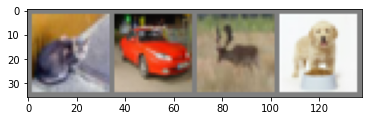

In [12]:
imshow(torchvision.utils.make_grid(images))

In [13]:
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  cat   car  deer   dog


## Defining a CNN

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input channel 6 output channel, 5x5 kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Max pooling 2x2 kernel
        self.pool = nn.MaxPool2d(2, 2)
        
        # 6 input channel 16 output channel, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # fully connected layer
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # 28x28 (after conv1) --> 14x14 (after pooling)
        x = self.pool(F.relu(self.conv2(x)))
        # 10x10 (after conv2) --> 5x5 (after pooling)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [18]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
import torch.optim as optim

In [21]:
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):  # start from index 0
        inputs, labels = data
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = ce_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # printing stats
        running_loss +=loss.item()
            
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print("Finished Training")

[1,  2000] loss: 2.243
[1,  4000] loss: 1.927
[1,  6000] loss: 1.750
[1,  8000] loss: 1.626
[1, 10000] loss: 1.544
[1, 12000] loss: 1.471
[2,  2000] loss: 1.427
[2,  4000] loss: 1.418
[2,  6000] loss: 1.394
[2,  8000] loss: 1.359
[2, 10000] loss: 1.339
[2, 12000] loss: 1.319
[3,  2000] loss: 1.258
[3,  4000] loss: 1.251
[3,  6000] loss: 1.258
[3,  8000] loss: 1.220
[3, 10000] loss: 1.205
[3, 12000] loss: 1.216
Finished Training


In [25]:
# Save the trained model
import os
os.mkdir('./model_checkpoints')
PATH = './model_checkpoints/cifar10_net.pth'
torch.save(net.state_dict(), PATH)

## Test

In [26]:
test_iter = iter(testloader)
images, labels = test_iter.next()

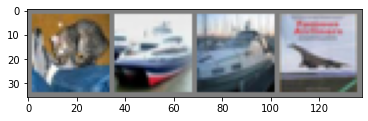

In [27]:
imshow(torchvision.utils.make_grid(images))

In [28]:
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:    cat  ship  ship plane


In [31]:
# Load trained model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [32]:
outputs = net(images)

In [34]:
_, predicted = torch.max(outputs, 1)

In [35]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


## Check correctly and wrongly classified images

In [43]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 86 %
Accuracy of  bird : 31 %
Accuracy of   cat : 49 %
Accuracy of  deer : 50 %
Accuracy of   dog : 42 %
Accuracy of  frog : 65 %
Accuracy of horse : 64 %
Accuracy of  ship : 70 %
Accuracy of truck : 40 %
